1. Calculate the average of the label column as initially this average shall minimise the total error
2. Calculate the pseudo residuals. 

Pseudo Residuals = actual label - predicted result (which is average in the first iteration)

3. Create a tree to predict the pseudo residuals instead of a tree to predict for the actual column values
4. New result = previous result + learning rate * residual

Repeat these steps until residual stops decreasing

In [33]:
#Important Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing, Normalizing

from sklearn.preprocessing import StandardScaler

#Models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

#Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

#Metrics

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, r2_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

In [5]:
df = pd.read_csv('heart diesease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [7]:
df.shape

(303, 14)

In [8]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

## Outlier detection (only to continous data)

In [10]:
df_features = df[['age', 'trestbps', 'chol', 'thalach']]

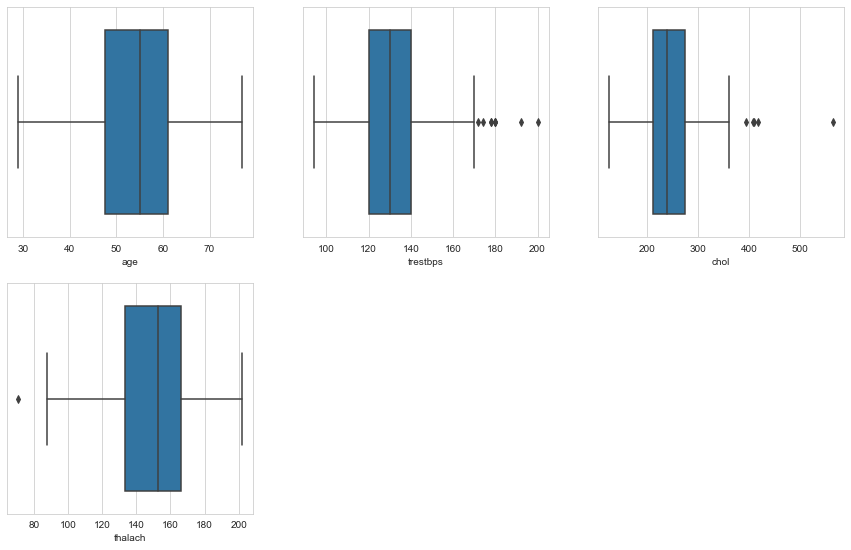

In [11]:
plt.figure(figsize=(15,50))
graph = 1

for column in df_features:
    if graph<=30:
        ax = plt.subplot(10, 3, graph)
        sns.boxplot(df_features[column], orient = 'v')
        plt.xlabel(column, fontsize = 10)
        
    graph+=1
plt.show()

In [12]:
#Find the IQR to identify outliers
q1 = df.quantile(0.25)

q3 = df.quantile(0.75)

iqr = q3 - q1

In [14]:
#validating one outlier
out_trestbps = (q3.trestbps + (1.5 * iqr.trestbps))
out_trestbps

170.0

### Outlier removal

In [15]:
index = np.where(df['trestbps'] > out_trestbps)
index

(array([  8, 101, 110, 203, 223, 241, 248, 260, 266], dtype=int64),)

In [16]:
df = df.drop(df.index[index])

In [17]:
df.shape

(294, 14)

In [18]:
df.reset_index()

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
290,299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
291,300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
292,301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [19]:
index = np.where(df['chol'] > (q3.chol + (1.5 * iqr.chol)))
df = df.drop(df.index[index])
print('Shape: ', df.shape)
df.reset_index()

Shape:  (289, 14)


,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
285,299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
286,300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
287,301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [20]:
index = np.where(df['thalach'] < (q1.thalach - (1.5 * iqr.thalach)))
df = df.drop(df.index[index])
print('Shape: ', df.shape)
df.reset_index()

Shape:  (288, 14)


,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
284,299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
285,300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
286,301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [21]:
#Just find correlation of feature vs target using corrwith
df.drop('target', axis = 1).corrwith(df.target)

age        -0.228234
sex        -0.313090
cp          0.426658
trestbps   -0.120231
chol       -0.109798
fbs        -0.021873
restecg     0.154995
thalach     0.431206
exang      -0.431165
oldpeak    -0.444884
slope       0.345785
ca         -0.388963
thal       -0.347019
dtype: float64

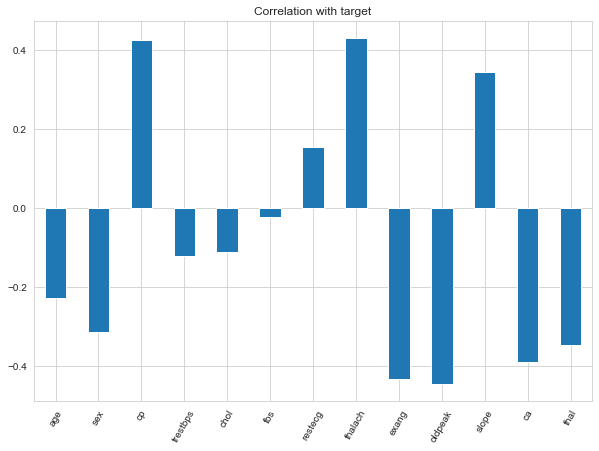

In [22]:
df.drop('target', axis = 1).corrwith(df.target).plot(kind = 'bar', grid = True, figsize = (10, 7), rot = 60,
                                                    title = 'Correlation with target')
plt.show()

#### Lets play around with feature selection and see if that can help us building better model

### Model building using SelectPercentile features

In [23]:
from sklearn.feature_selection import SelectPercentile, chi2

When we apply chi2, we get p value for all the features. Based on p values, it will select top 80% of features

In [24]:
X = df.drop(columns = 'target')
y = df['target']

In [27]:
SPercentile = SelectPercentile(score_func = chi2, percentile = 80)
SPercentile = SPercentile.fit(X, y)

In [28]:
#Separate the features to check p values
cols = SPercentile.get_support(indices = True)
features = X.columns[cols]

In [29]:
df_scores = pd.DataFrame({'features': X.columns, 'Chi2score': SPercentile.scores_, 'pvalue': SPercentile.pvalues_})
df_scores.sort_values(by = 'Chi2score', ascending = False)

,features,Chi2score,pvalue
7,thalach,183.939648,6.687836e-42
9,oldpeak,72.526212,1.648281e-17
11,ca,62.427456,2.764423e-15
2,cp,56.872707,4.649541e-14
8,exang,36.437110,1.576724e-09
4,chol,28.993682,7.261473e-08
0,age,22.988951,1.629352e-06
10,slope,9.123232,2.523837e-03
1,sex,8.430178,3.690442e-03
3,trestbps,7.581362,5.897487e-03


Lets print top 80% features

In [30]:
print(cols)
print(features)

[ 0  1  2  3  4  7  8  9 10 11]
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak',
       'slope', 'ca'],
      dtype='object')


In [31]:
# Create subset of selected features
X = df[features]
y = df.target

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)

In [35]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)

pred = gb.predict(x_train)
gb_report_train = pd.DataFrame(classification_report(y_train, pred, output_dict = True))

print("\n=============TRAIN RESULT==============")
print(f'Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%')
print(f'Classification Report: \n {gb_report_train}')
print(f'Confusion Matrix:\n {confusion_matrix(y_train, pred)}')

pred = gb.predict(x_test)
gb_report_test = pd.DataFrame(classification_report(y_test, pred, output_dict = True))

print('\n==============TEST RESULT===============')
print(f'Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%')
print(f'Classification Report: \n {gb_report_test}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, pred)}')


=============TRAIN RESULT==============
Accuracy Score: 100.00%
Classification Report: 
               0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    93.0  108.0       1.0      201.0         201.0
Confusion Matrix:
 [[ 93   0]
 [  0 108]]

==============TEST RESULT===============
Accuracy Score: 77.01%
Classification Report: 
                    0          1  accuracy  macro avg  weighted avg
precision   0.690476   0.844444  0.770115   0.767460      0.780733
recall      0.805556   0.745098  0.770115   0.775327      0.770115
f1-score    0.743590   0.791667  0.770115   0.767628      0.771773
support    36.000000  51.000000  0.770115  87.000000     87.000000
Confusion Matrix:
 [[29  7]
 [13 38]]


### Hyperparameter Tuning

In [36]:
grid_param = {
    'max_depth': range(4, 12, 2),
    'learning_rate': np.arange(0.1, 1, 0.1),
    'min_samples_split': range(4, 8, 2)
}

In [37]:
grid = GridSearchCV(gb, param_grid = grid_param)
grid.fit(x_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': range(4, 12, 2),
                         'min_samples_split': range(4, 8, 2)})

In [38]:
grid.best_params_

{'learning_rate': 0.8, 'max_depth': 10, 'min_samples_split': 4}

In [39]:
gb = GradientBoostingClassifier(max_depth = 10, min_samples_split = 4, learning_rate = 0.8)
gb.fit(x_train, y_train)

pred = gb.predict(x_train)
gb_report_train = pd.DataFrame(classification_report(y_train, pred, output_dict = True))

print("\n=============TRAIN RESULT==============")
print(f'Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%')
print(f'Classification Report: \n {gb_report_train}')
print(f'Confusion Matrix:\n {confusion_matrix(y_train, pred)}')

pred = gb.predict(x_test)
gb_report_test = pd.DataFrame(classification_report(y_test, pred, output_dict = True))

print('\n==============TEST RESULT===============')
print(f'Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%')
print(f'Classification Report: \n {gb_report_test}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, pred)}')


=============TRAIN RESULT==============
Accuracy Score: 100.00%
Classification Report: 
               0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    93.0  108.0       1.0      201.0         201.0
Confusion Matrix:
 [[ 93   0]
 [  0 108]]

==============TEST RESULT===============
Accuracy Score: 72.41%
Classification Report: 
                    0          1  accuracy  macro avg  weighted avg
precision   0.642857   0.800000  0.724138   0.721429      0.734975
recall      0.750000   0.705882  0.724138   0.727941      0.724138
f1-score    0.692308   0.750000  0.724138   0.721154      0.726127
support    36.000000  51.000000  0.724138  87.000000     87.000000
Confusion Matrix:
 [[27  9]
 [15 36]]
